<a href="https://colab.research.google.com/github/somil2601/practice-data/blob/main/PXT904_MODELLING_ASSIGNMENT_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling Assignment

Work individually and always feel free to ask questions.

## Instructions for submission

To submit your work, save the notebook with the following filename:

`LAST_NAME_PXT904_MODELLING_ASSIGNMENT.ipynb`

# Introduction

In this assignment you will get some hands-on experience modelling gravitational waveforms extracted from Numerical Relativity simulations.
Numerical relativity simulations often provide our best estimate of the gravitational-wave signal from merging black holes.
The high accuracy data from these simulations comes with a high computational cost, however, which limits the number of simulations that can be performed in a reasonable time.

To provide useful tools for gravitational-wave astronomy we can take discrete numerical-relativity data and make a continuous *model* by, for example, interpolating or fitting the NR data.

In this assignment you will get a flavour for what this is like to do in practice.

## Loading the NR data

I have uploaded a zip file containing the directory `PXT904-waveform-modelling-data` to learning central, which also contains two sub-directories: `PXT904_training_data` and `PXT904_validation_data`.

Often in a modelling problem you will have two sets of data.

**Training data:** used to train/calibrate your model and

**Validation data:** not used to train/calibrate your model but instead used to test (or validate) that your model has not been *overfit* to your training data.

If your model also performs well on the validation data then we can say that
your model has *generalised* well to data outside of the training set.
This is a vital part of modelling, as one of the main goals of modelling is to predict a quantity for points in parameter space where we do not have data.

You should upload these data to your google drive. After you have done this you should be able to run the next code block and authorize the mount request, which will allow you to load the data in your google drive into this google colab instance.

If this isn't working then email me and I will help get this working.

In [81]:
# coonect your google drive to this colab instance so that you can load the training and validation data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 18})

In [83]:
# if you put the `PXT904-waveform-modelling-data` directory into your root google drive then these lines of code should be the same for you.
training_data_directory = "/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_training_data"
validation_data_directory = "/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_validation_data"

In [84]:
# we can use `glob` to get a list of the paths to the data files.
training_data_filenames = glob.glob(f"{training_data_directory}/*.txt")
validation_data_filenames = glob.glob(f"{validation_data_directory}/*.txt")

In [85]:
# here we simply print the paths to the training and validation data to see what we have.
print("training data")
for fil in training_data_filenames:
    print(fil)

print("")

print("validation data")
for fil in validation_data_filenames:
    print(fil)

training data
/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_training_data/q_3.0.txt
/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_training_data/q_5.0.txt
/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_training_data/q_1.0.txt
/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_training_data/q_9.5.txt
/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_training_data/q_9.0.txt
/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_training_data/q_4.0.txt
/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_training_data/q_4.5.txt

validation data
/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_validation_data/q_10.0.txt
/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_validation_data/q_2.0.txt
/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_validation_data/q_3.5.txt


This dataset contains the $(l, m)=(2, 2)$ gravitational wave multipole from a series of non-spinning binary-black-hole numerical-relativity waveforms.

We have 7 examples in our training set and 3 examples in our validation set.

Let's take a look at what the structure of the data is:

In [86]:
!head /content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_training_data/q_3.0.txt

-2.000000000000000000e+03 8.913342857378918349e-02 0.000000000000000000e+00 -4.548910106984414142e-02
-1.997897897897897792e+03 8.915709847478797689e-02 -9.563146363871055655e-02 -4.549751432135853285e-02
-1.995795795795795812e+03 8.918020652175491503e-02 -1.912812973898780911e-01 -4.550657891970583124e-02
-1.993693693693693604e+03 8.920267346467522507e-02 -2.869508704819878631e-01 -4.551629490901057395e-02
-1.991591591591591623e+03 8.922442004688599382e-02 -3.826415520400985315e-01 -4.552666200935324980e-02
-1.989489489489489415e+03 8.924536703617397260e-02 -4.783547114124928612e-01 -4.553768146725516164e-02
-1.987387387387387435e+03 8.926543510550460914e-02 -5.740917178952287259e-01 -4.554934882059187562e-02
-1.985285285285285227e+03 8.928454529645121762e-02 -6.698539405464032370e-01 -4.556168025720191972e-02
-1.983183183183183246e+03 8.930261722812696257e-02 -7.656428257044467500e-01 -4.557472543832798151e-02
-1.981081081081081038e+03 8.931958314922885944e-02 -8.614599113398355712e-

Each file has four columns:

- col 0: time, measured in units total mass $M$ (the total mass of these simulations have be scaled to 1)
- col 1: amplitude
- col 2: phase
- col 3: frequency

We can load the data into a python dictionary format to make it easier to access.

In [87]:
def load_data_into_dict(filenames):
    """
    this function takes a list of filenames and returns a dictionary of the data
    """
    data_dict = {}
    for filename in filenames:
        key = filename.split("/")[-1].split(".txt")[0]

        time, amp, phase, freq = np.loadtxt(filename, unpack=True)
        sub_dict = dict(time=time, amp=amp, phase=phase, freq=freq)

        data_dict.update({key:sub_dict})
    return data_dict

In [88]:
training_set_data = load_data_into_dict(training_data_filenames)
validation_set_data = load_data_into_dict(validation_data_filenames)

In [89]:
# to access different NR simulations we use the dictionary keys
training_set_data.keys()

dict_keys(['q_3.0', 'q_5.0', 'q_1.0', 'q_9.5', 'q_9.0', 'q_4.0', 'q_4.5'])

In [90]:
# each simulation contains the following data
# in the form of a dictionary
training_set_data['q_1.0'].keys()

dict_keys(['time', 'amp', 'phase', 'freq'])

In [91]:
validation_set_data.keys()

dict_keys(['q_10.0', 'q_2.0', 'q_3.5'])

It is often a good idea to plot the data before trying to fit it, as
you may be able to see some patterns that you can exploit in your modelling.
Here we simply plot the data labelled by mass-ratio, as this will be
the physically meaningful parameter that we will use as our
independent variable in our model.


We have already done some pre-processing of the data for you.
Specifically we have:
  - interpolated and resampled the data onto the same time grid
  - performed a time shift such that the peak of the amplitude is at $t=0M$
  - performed a phase shift such that the phase is zero at the start of the data ($t=-2000M$)

In [92]:
# a simple plotting function
def plot_data_dict(data_dict, title):
    ncols = 3
    nrows = 1
    xlabel = 'time / M'
    ylabels = {'amp':r"$|h_{22}|$", 'phase':r"$\phi_{22}$", 'freq':r"$\omega_{22}$"}
    plt.figure(figsize=(30, 8))
    for i, data_name in enumerate(['amp', 'phase', 'freq']):
        plt.subplot(nrows, ncols, i+1)
        for k in data_dict.keys():
            plt.plot(data_dict[k]['time'], data_dict[k][data_name], label=k)
        plt.legend()
        plt.title(data_name)
        plt.xlabel(xlabel)
        plt.ylabel(ylabels[data_name])
    plt.suptitle(f"{title}")

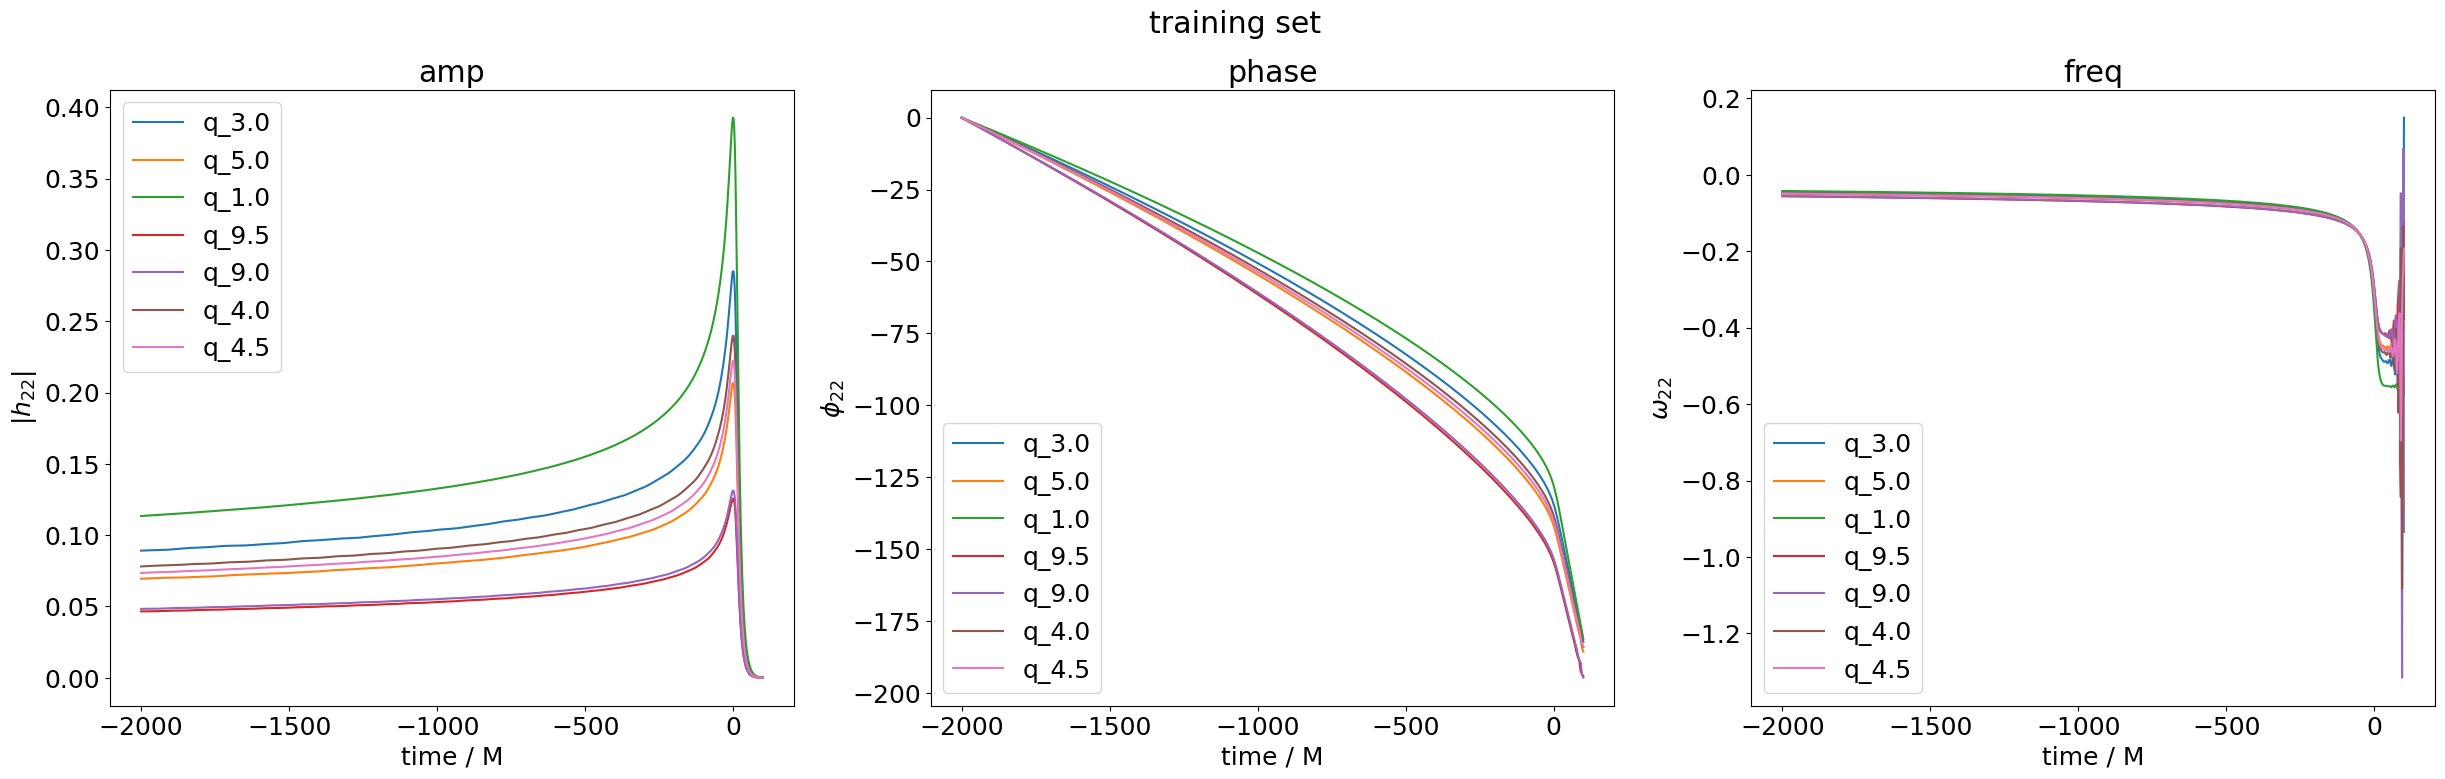

In [93]:
plot_data_dict(training_set_data, 'training set')

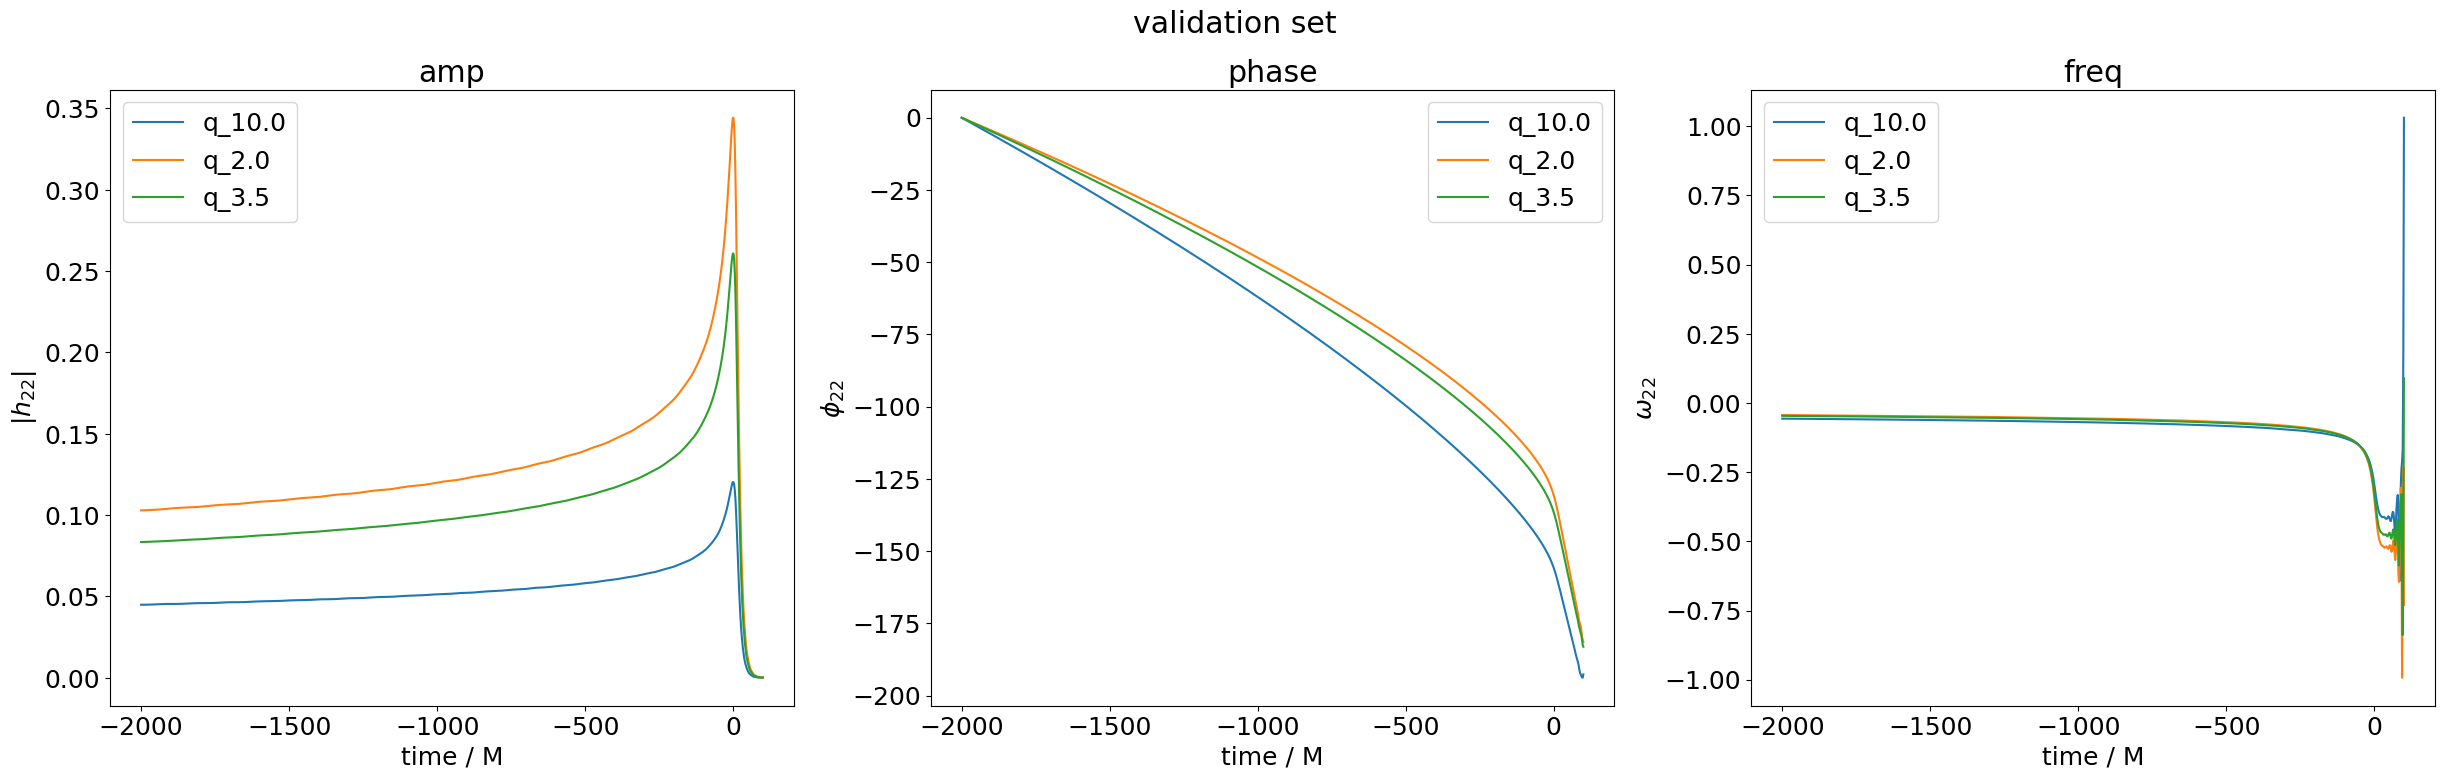

In [94]:
plot_data_dict(validation_set_data, 'validation set')

# Modelling assignment: modelling the final black hole ringdown frequency

Tasks:

**1.   Using the numerical relativity data above, extract an estimate for the remnant black-hole dimensionless angular ringdown frequency for each of the NR cases given in the dataset.**

*Hints:*

After the black holes merge, the frequency of the gravitational wave signal levels off to a constant value, the ringdown frequency. The data at this point slowly becomes inaccurate over time due to numerical noise.

This task mainly will involve deciding on an appropriate choice of start and end time over which to estimate the ringdown frequency.

**2.   Model/fit your estimate of the ringdown frequency as a function of mass-ratio**

*Hints:*

A simple polynomial fit should suffice. How did you settle on the order of polynomial you used?

**3.   Compare your estimate to black-hole perturbation theory. We have provided you with a fit from the literature that predicts the ringdown frequency of a perturbed black hole.**

*Hints:*

In General Relativity, astrophysical black holes are described entirely by 2 numbers: their mass and spin angular momentum. Also, final mass and spin, and results from perturbation theory, and useful results from the literature, are given in the Lecture Notes on final mass and spin, from Week 7.



## Helper functions

These functions may be useful.

The data are labelled by the mass-ratio $q = m_1 / m_2$ where $m_1 \geq m_2 $.
However, equations are often written in terms of the symmetric-mass-ratio $\eta = \frac{m_1 m_2}{(m_1+m_2)^2}$.

You can use the function `eta_from_q` to convert from mass-ratio to symmetric-mass-ratio.

In [95]:
def eta_from_q(q):
    """
    converts mass-ratio to symmetric mass-ratio assuming the total mass is 1.
    input: q
    output: eta
    """
    return q/(1.+q)**2

The function `perturbation_theory_fit` is a fit from the literature that predicts the ringdown frequency of a perturbed black hole.

In [96]:
def perturbation_theory_fit(spin, M=1):
    """
    equation 96: arxiv: 0905.2975
    fit to BH perturbation theory that predicts the ringdown frequency of a perturbed black hole.

    input:
        spin (float), dimensionless spin of the black hole
        M (float), defaults to 1. The mass of the black hole

    """
    bhat = 1-spin/M
    # minus sign to match our convention
    return -(1.5251 - 1.1568 * bhat**0.1292)

# Your work here

Question 1: Using the numerical relativity data above, extract an estimate for the remnant black-hole dimensionless angular ringdown frequency for each of the NR cases given in the dataset.

The maximum amplitudes due to merger is:  0.3927549185768476 0.2851112463192625 0.23995581063750224 0.22230514013566197 0.2066633722469823 0.13126881228827447 0.12556024898744012


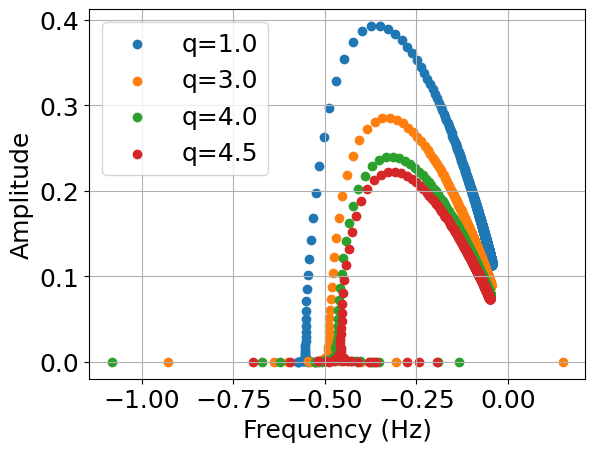

In [97]:
import pandas as pd

data1 = pd.read_csv(r'/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_training_data/q_1.0.txt', sep=" ", header=None)
data2 = pd.read_csv(r'/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_training_data/q_3.0.txt', sep=" ", header=None)
data3 = pd.read_csv('/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_training_data/q_4.0.txt', sep=" ", header=None)
data4 = pd.read_csv('/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_training_data/q_4.5.txt', sep=" ", header=None)
data5 = pd.read_csv('/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_training_data/q_5.0.txt', sep=" ", header=None)
data6 = pd.read_csv('/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_training_data/q_9.0.txt', sep=" ", header=None)
data7 = pd.read_csv('/content/drive/MyDrive/PXT904-waveform-modelling-data/PXT904_training_data/q_9.5.txt', sep=" ", header=None)

data1 = np.array(data1)
data2 = np.array(data2)
data3 = np.array(data3)
data4 = np.array(data4)
data5 = np.array(data5)
data6 = np.array(data6)
data7 = np.array(data7)

max_amp1 = np.max(data1[:,1])
max_amp2 = np.max(data2[:,1])
max_amp3 = np.max(data3[:,1])
max_amp4 = np.max(data4[:,1])
max_amp5 = np.max(data5[:,1])
max_amp6 = np.max(data6[:,1])
max_amp7 = np.max(data7[:,1])

print('The maximum amplitudes due to merger is: ',max_amp1, max_amp2, max_amp3, max_amp4, max_amp5, max_amp6, max_amp7)

plt.scatter(data1[:,3], data1[:,1], label='q=1.0')
plt.scatter(data2[:,3], data2[:,1], label='q=3.0')
plt.scatter(data3[:,3], data3[:,1], label='q=4.0')
plt.scatter(data4[:,3], data4[:,1], label='q=4.5')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()






q = 1.0: -86.59523725820044
q = 3.0: -86.57146563666714
q = 4.0: -87.81506731949726
q = 4.5: -87.64392617240367
q = 5.0: -88.61198304173321
q = 9.0: -93.29857318300756
q = 9.5: -92.48223354925555


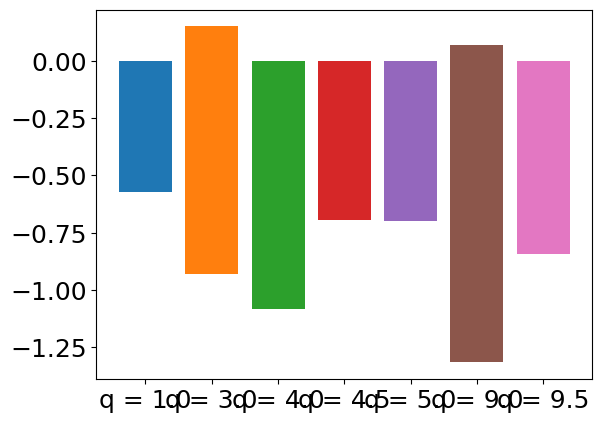

<Figure size 1000x500 with 0 Axes>

In [114]:
# Assuming your datasets are NumPy arrays

datasets = {
    'q = 1.0': data1,
    'q = 3.0': data2,
    'q = 4.0': data3,
    'q = 4.5': data4,
    'q = 5.0': data5,
    'q = 9.0': data6,
    'q = 9.5': data7
}
dataset = {key: df[:, 3] for key, df in datasets.items()}

for key, column in dataset.items():
    combine = column.sum()
    print(f"{key}: {combine}")
    plt.bar(key,column)

plt.figure(figsize=(10, 5))
plt.show()








In [99]:
for key, data in datasets.items():
    t = data[:, 0]
    f = data[:, 3]
    print(f"Data for {key}:")
    print("Time:", t)
    print("Frequency:", f)
    print()

for key1, df in datasets.items():
    print(f"{key1}:")
    print(df)
    print()


Data for q = 1.0:
Time: [-2.00000000e+03 -1.99789790e+03 -1.99579580e+03 -1.99369369e+03
 -1.99159159e+03 -1.98948949e+03 -1.98738739e+03 -1.98528529e+03
 -1.98318318e+03 -1.98108108e+03 -1.97897898e+03 -1.97687688e+03
 -1.97477477e+03 -1.97267267e+03 -1.97057057e+03 -1.96846847e+03
 -1.96636637e+03 -1.96426426e+03 -1.96216216e+03 -1.96006006e+03
 -1.95795796e+03 -1.95585586e+03 -1.95375375e+03 -1.95165165e+03
 -1.94954955e+03 -1.94744745e+03 -1.94534535e+03 -1.94324324e+03
 -1.94114114e+03 -1.93903904e+03 -1.93693694e+03 -1.93483483e+03
 -1.93273273e+03 -1.93063063e+03 -1.92852853e+03 -1.92642643e+03
 -1.92432432e+03 -1.92222222e+03 -1.92012012e+03 -1.91801802e+03
 -1.91591592e+03 -1.91381381e+03 -1.91171171e+03 -1.90960961e+03
 -1.90750751e+03 -1.90540541e+03 -1.90330330e+03 -1.90120120e+03
 -1.89909910e+03 -1.89699700e+03 -1.89489489e+03 -1.89279279e+03
 -1.89069069e+03 -1.88858859e+03 -1.88648649e+03 -1.88438438e+03
 -1.88228228e+03 -1.88018018e+03 -1.87807808e+03 -1.87597598e+03
 

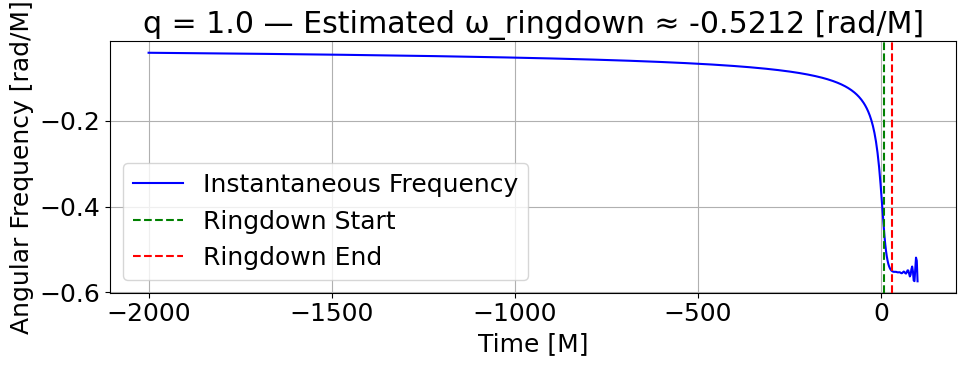

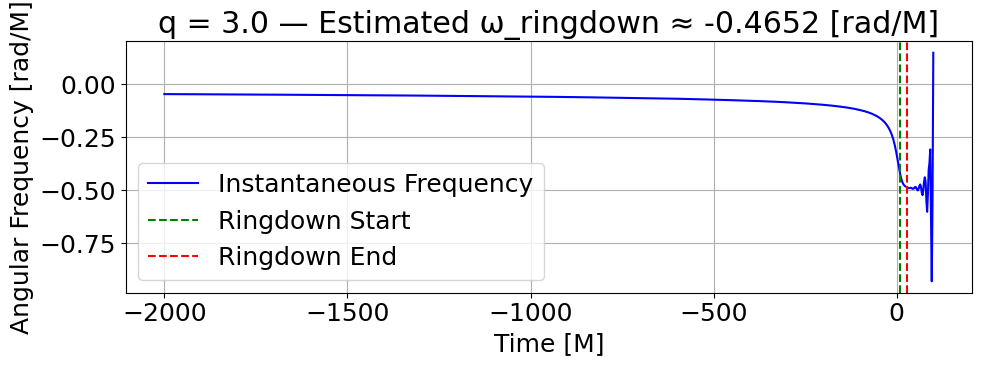

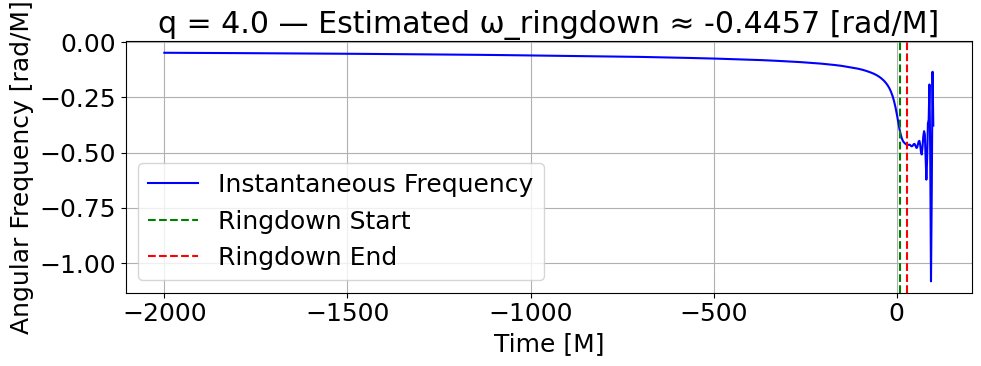

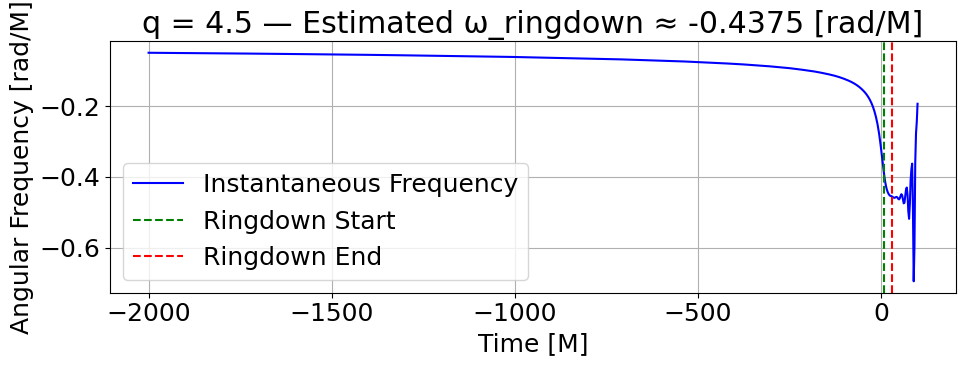

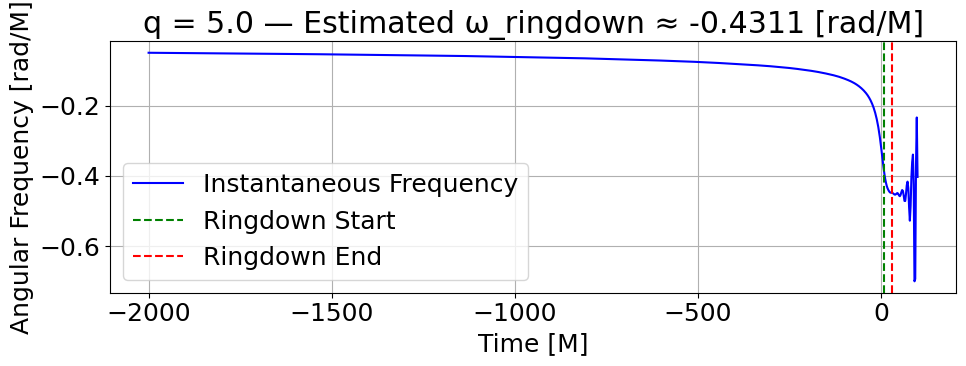

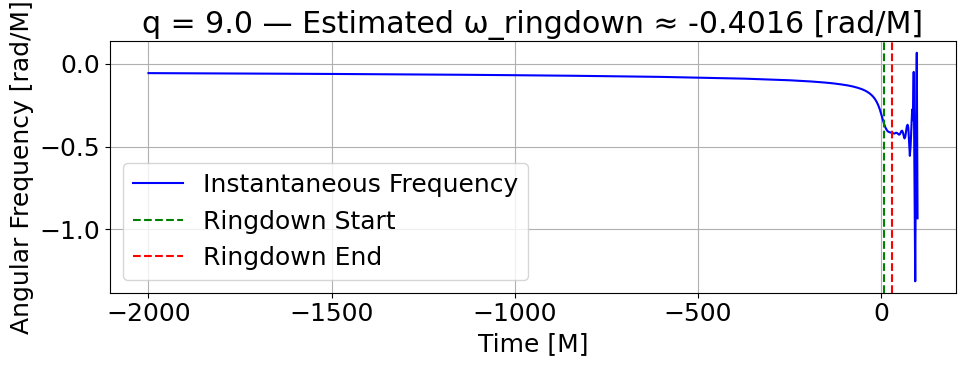

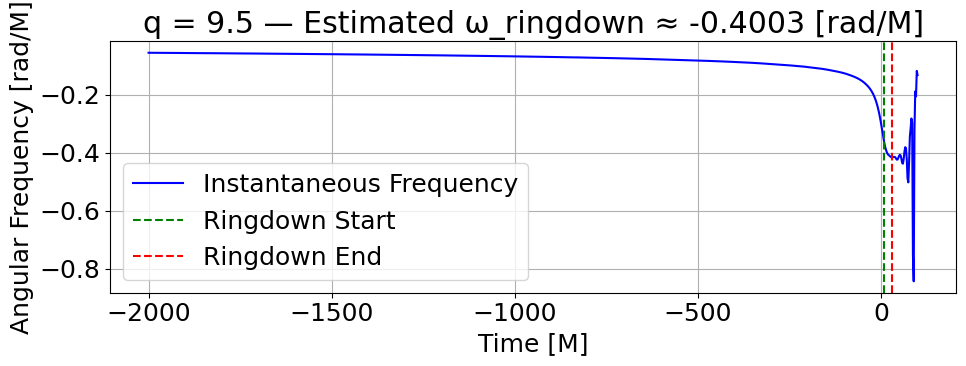


Estimated Dimensionless Angular Ringdown Frequencies (ω_ringdown):
q = 1.0: ω ≈ -0.5212 rad/M
q = 3.0: ω ≈ -0.4652 rad/M
q = 4.0: ω ≈ -0.4457 rad/M
q = 4.5: ω ≈ -0.4375 rad/M
q = 5.0: ω ≈ -0.4311 rad/M
q = 9.0: ω ≈ -0.4016 rad/M
q = 9.5: ω ≈ -0.4003 rad/M


In [100]:
def estimate_ringdown_frequency(data, label, ringdown_offset_start=10, ringdown_offset_end=30):
    # Unpack the data columns.
    t = data[:, 0]
    amplitude = data[:, 1]
    phase = data[:, 2]
    freq = data[:, 3]

    # Identify the merger time using the maximum of the amplitude.
    merger_index = np.argmax(amplitude)
    merger_time = t[merger_index]

    # Define the ringdown window: starting ringdown_offset_start after merger
    # and ending at ringdown_offset_end after merger.
    t_start = merger_time + ringdown_offset_start
    t_end = merger_time + ringdown_offset_end
    window_mask = (t >= t_start) & (t <= t_end)

    # Calculate the average ringdown frequency over the chosen window.
    ringdown_freq = np.mean(freq[window_mask])

    # Plotting the instantaneous frequency along with the selected ringdown interval.
    plt.figure(figsize=(10, 4))
    plt.plot(t, freq, label="Instantaneous Frequency", color='blue')
    plt.axvline(t_start, color="green", linestyle="--", label="Ringdown Start")
    plt.axvline(t_end, color="red", linestyle="--", label="Ringdown End")
    plt.title(f"{label} — Estimated ω_ringdown ≈ {ringdown_freq:.4f} [rad/M]")
    plt.xlabel('Time [M]')
    plt.ylabel('Angular Frequency [rad/M]')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return ringdown_freq

# Example of processing the datasets:
# Assume data1, data2, ... data7 are already loaded as NumPy arrays.
datasets = {
    'q = 1.0': data1,
    'q = 3.0': data2,
    'q = 4.0': data3,
    'q = 4.5': data4,
    'q = 5.0': data5,
    'q = 9.0': data6,
    'q = 9.5': data7
}

ringdown_frequencies = {}
for label, data in datasets.items():
    freq_est = estimate_ringdown_frequency(data, label)
    ringdown_frequencies[label] = freq_est

# Output the estimated frequencies.
print("\nEstimated Dimensionless Angular Ringdown Frequencies (ω_ringdown):")
for label, freq in ringdown_frequencies.items():
    print(f"{label}: ω ≈ {freq:.4f} rad/M")


In [101]:
import numpy as np

t = data[:, 0]
amplitude = data[:, 1]
phase = data[:, 2]
freq = data[:, 3]

# Corrected formula: Using np.pi instead of np
formula = amplitude * np.exp(1j * 2 * np.pi * t)

formula.sum()

np.complex128(0.013754149645065189+0.07063324431907358j)

2.  Model/fit your estimate of the ringdown frequency as a function of mass-ratio